In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt
import matplotlib.pyplot as plt
from imgcube.cube import imagecube

In [28]:
# Load data and convert to [K] with RJ approximation.
cube = imagecube('../data/cont/TWHya.345GHz.circ.fits', clip=1.1, kelvin='RJ')

In [29]:
# Pre-compute the arrays and grab a random subsample of them.
np.random.seed(1234)
X, Y = np.meshgrid(cube.xaxis, cube.yaxis)
y = np.array(cube.data, dtype=np.float64).flatten()
mask = (y > 0.0) & (np.random.rand(len(y)) < 1.0)
mask = mask & (np.hypot(X, Y) <= 1.0).flatten()
X = X.flatten()[mask]
Y = Y.flatten()[mask]
y = np.log(y[mask])

In [30]:
# Define the deprojection function.
def deproject(x0, y0, inc, PA, w0, i0, r0):
    """
    Deproject the disk coordinates including a warped surface.
    If the disk is highly inclined or there are big perturbations, 
    some pixels may be shadowed and convergence is not good.
    """
    
    # Get the rotated disk coordiantes.
    x_sky, y_sky = X - x0, Y - y0
    x_rot = y_sky * tt.cos(PA) + x_sky * tt.sin(PA)
    y_rot = x_sky * tt.cos(PA) - y_sky * tt.sin(PA)
    
    # Iterate to account for warp.
    # Increase iterations for better convergence.
    y_tmp = y_rot / tt.cos(inc)
    for _ in range(5):
        r_tmp = tt.sqrt(x_rot**2 + y_tmp**2)
        t_tmp = tt.arctan2(y_tmp, x_rot)
        w_tmp = i0 * tt.exp(-0.5*((r_tmp / r0)**2))
        z_tmp = r_tmp * np.tan(w_tmp) * np.sin(t_tmp - w0)
        y_tmp = y_rot / tt.cos(inc) - z_tmp * tt.tan(inc)
    r_disk = tt.sqrt(x_rot**2 + y_tmp**2)
    t_disk = tt.arctan2(y_tmp, x_rot)
    return r_disk, t_disk

In [31]:
with pm.Model() as model:
    
    # Geometrical properties
    x0 = pm.Normal("x0", mu=0.0, sd=0.1)
    y0 = pm.Normal("y0", mu=0.0, sd=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=0.2*np.pi)
    pa_deg = pm.Uniform("pa_deg", lower=130., upper=170.)
    pa = pa_deg * np.pi / 180.0
    
    # Warp properties
    w0 = pm.Uniform("w0", lower=-0.5*np.pi, upper=0.5*np.pi)
    i0 = pm.Uniform("i0", lower=-0.3, upper=0.3)
    r0 = pm.Uniform("r0", lower=0.0, upper=3.0)
    
    # Mean model
    mu = pm.Normal("mu", mu=np.mean(y), sd=100.0)
    slope = pm.Normal("slope", mu=0.0, sd=100.0)
    
    # Get the projected coordinates
    r, t = deproject(x0, y0, inc, pa, w0, i0, r0)
    #r, t = deproject_flat(x0, y0, inc, pa)
    inds = tt.argsort(r)
    
    # Sort by radius
    r_sort = r[inds]
    y_sort = tt.as_tensor_variable(y)[inds]
    
    # Jitter & GP parameters
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=10)
    logw0_guess = np.log(2*np.pi/0.1)
    logtau = pm.Bound(pm.Normal, upper=2.0)(
        "logtau", mu=np.log(2*np.pi)-logw0_guess, sd=10)
    logw0 = np.log(2*np.pi) - logtau

    # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
    # S_0 directly because this removes some of the degeneracies between
    # S_0 and omega_0
    logpower = pm.Normal("logpower",
                         mu=np.log(np.var(y))+4*logw0_guess,
                         sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

    # Setup the GP
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, r_sort, tt.exp(0.5*logs2) + np.zeros_like(y), J=2)
    
    # Compute the mean model
    line = mu + slope * r_sort
    
    # Compute the GP likelihood and predictions
    pm.Potential("loglike", gp.log_likelihood(y_sort - line))
    gp_pred = gp.predict() + line
    
    # Optimize to find the MAP
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, vars=[logs2, mu, slope])
    map_soln = xo.optimize(map_soln)
    map_soln = xo.optimize(map_soln, vars=[x0, y0])
    map_soln = xo.optimize(map_soln)
    map_soln = xo.optimize(map_soln, vars=[inc, pa_deg])
    map_soln = xo.optimize(map_soln)
    map_soln = xo.optimize(map_soln, vars=[logs2, logpower, logtau])
    map_soln = xo.optimize(map_soln)
    #map_soln = xo.optimize(map_soln, vars=[w0, i0, r0])
    map_soln = xo.optimize(map_soln)

optimizing logp for variables: ['slope', 'mu', 'logs2']
message: Desired error not necessarily achieved due to precision loss.
logp: -234514.0616640487 -> 8465.071020243784
optimizing logp for variables: ['logpower', 'logtau_upperbound__', 'logs2', 'slope', 'mu', 'r0_interval__', 'i0_interval__', 'w0_interval__', 'pa_deg_interval__', 'inc_interval__', 'y0', 'x0']
message: Desired error not necessarily achieved due to precision loss.
logp: 8465.071020243784 -> 358455.14661638
optimizing logp for variables: ['y0', 'x0']
message: Desired error not necessarily achieved due to precision loss.
logp: 358455.14661638 -> 358455.14661638
optimizing logp for variables: ['logpower', 'logtau_upperbound__', 'logs2', 'slope', 'mu', 'r0_interval__', 'i0_interval__', 'w0_interval__', 'pa_deg_interval__', 'inc_interval__', 'y0', 'x0']
message: Desired error not necessarily achieved due to precision loss.
logp: 358455.14661638 -> 358455.14661638
optimizing logp for variables: ['pa_deg_interval__', 'inc_i

MAP inclination: 30.45 degrees.
MAP position angle: 169.95 degrees.


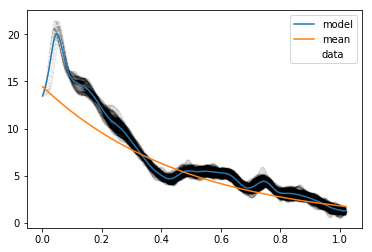

In [32]:
with model:
    a, b, c, d = xo.utils.eval_in_model([r_sort, y_sort, gp_pred, line], map_soln)
print('MAP inclination: %.2f degrees.' % np.degrees(map_soln['inc']))
print('MAP position angle: %.2f degrees.' % map_soln['pa_deg'])
print('MAP {i0, r0, w0} = {%.2f, %.2f, %.2f}' % (map_soln["i0"], map_soln["r0"], map_soln["w0"]))
plt.scatter(a, np.exp(b), label="data", s=1, c='k', alpha=0.02)
plt.plot(a, np.exp(c), label="model")
plt.plot(a, np.exp(d), label="mean")
plt.legend()

In [34]:
np.radians(15.0)

0.2617993877991494